In [1]:
# !export CUDA_VISIBLE_DEVICES=1

In [2]:
! pip uninstall -y kaggle_brain3d
#! pip install -q https://github.com/Borda/kaggle_brain-tumor-3D/archive/refs/heads/main.zip
# ! pip install -q https://github.com/Borda/kaggle_brain-tumor-3D/archive/refs/tags/v0.3.2.zip
!pip install -q /DATA/DAT-BrainProj/main.zip
! pip install -q "pytorch-lightning>=1.3.8"
! pip uninstall -q -y wandb
# !pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
! pip list | grep torch

Found existing installation: kaggle-brain3D 0.4.0
Uninstalling kaggle-brain3D-0.4.0:
  Successfully uninstalled kaggle-brain3D-0.4.0
pytorch-lightning       1.3.8
torch                   1.10.0
torchaudio              0.10.0
torchfile               0.1.0
torchmetrics            0.6.2
torchsummary            1.5.1
torchvision             0.11.1


# Final Project
# Predict the MGMT methylation status using MRI from patients with brain tumor

Student: Le Thanh Dat - 208181

The goal of this challenge is to Predict the status of a genetic biomarker important for brain cancer treatment.

All thanks to public repository: https://github.com/Borda/kaggle_brain-tumor-3D

In [3]:
! ls -l /DATA/DAT-BrainProj
! nvidia-smi -L
! mkdir /DATA/DAT-BrainProj/temp

total 11563436
drwxrwxr-x   8 user user        4096 Dec 17 12:25  kaggle_brain-tumor-3D
-rw-rw-r--   1 user user   341350707 Dec 19 05:49  main.zip
drwxrwxr-x   8 user user        4096 Dec 19 01:23  MedicalNet
drwxrwxr-x   5 user user        4096 Dec 19 02:09  MedicalNet-pytorch
drwxrwxr-x   4 user user        4096 Dec 19 05:54  PrjBrain
-rwxrwxrwx   1 user user 11499207193 Dec 17 04:56  PrjBrain.zip
drwxrwxr-x 403 user user       12288 Dec 19 07:27  temp
-rw-rw-r--   1 user user      364329 Dec 19 03:58 'Untitled 1.odp'
GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-1874c0ec-fed4-4a78-1bac-0af1cf9a8b99)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-ffe24aa6-dd58-deaf-6e69-90c64e232eed)
mkdir: cannot create directory ‘/DATA/DAT-BrainProj/temp’: File exists


In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
import sys
import os

#Modified libraries (Most functions are cloned from public respository)
sys.path.insert(0, '/DATA/DAT-BrainProj/kaggle_brain-tumor-3D/kaggle_brain3d/')

import kaggle_brain3d

## Data explaination

PatientID: Each independent case has a dedicated folder identified by a five-digit number. (example: 00099)
Each of these “PatientID” folders: two sub-folders
- **FLAIR**: Fluid Attenuated Inversion Recovery
- **T1wCE**: T1-weighted post-contrast

In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH_DATASET = "/DATA/DAT-BrainProj/PrjBrain"
PATH_MODELS = "/DATA/DAT-BrainProj/MedicalNet-pytorch/pretrain"
PATH_TEMP = "/DATA/DAT-BrainProj/temp/brain-tumor"
SCAN_TYPES = ("FLAIR","T1wCE")

df_train = pd.read_csv(os.path.join(PATH_DATASET, "train_labels.csv"))
df_train["PatientID"] = df_train["PatientID"].apply(lambda i: "%05d" % i)
display(df_train.head())

,PatientID,ClassLabel
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1


See the dataset label distribution

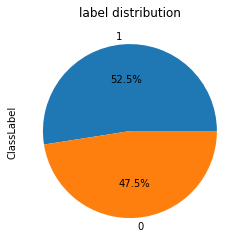

In [7]:
_= df_train["ClassLabel"].value_counts().plot(kind="pie", title="label distribution", autopct="%.1f%%")

For almost all scans we have all four types

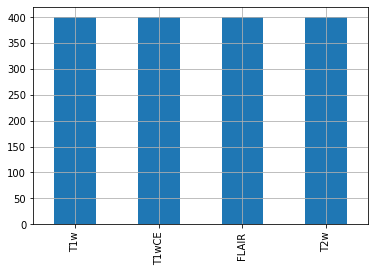

In [8]:
scans = [os.path.basename(p) for p in glob.glob(os.path.join(PATH_DATASET, "train", "*", "*"))]
_= pd.Series(scans).value_counts().plot(kind="bar", grid=True)

### Interactive view

showing particular scan in XYZ dimension/slices

In [9]:
from ipywidgets import interact, IntSlider

from kaggle_brain3d.utils import load_volume, interpolate_volume, show_volume
from kaggle_brain3d.transforms import crop_volume


def interactive_show(volume_path: str, crop_thr: float):
    print(f"loading: {volume_path}")
    volume = load_volume(volume_path, percentile=0)
    print(f"sample shape: {volume.shape} >> {volume.dtype}")
    volume = interpolate_volume(volume)
    print(f"interp shape: {volume.shape} >> {volume.dtype}")
    volume = crop_volume(volume, crop_thr)
    print(f"crop shape: {volume.shape} >> {volume.dtype}")
    vol_shape = volume.shape
    interact(
        lambda x, y, z: plt.show(show_volume(volume, x, y, z)),
        x=IntSlider(min=0, max=vol_shape[0], step=5, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1], step=5, value=int(vol_shape[1] / 2)),
        z=IntSlider(min=0, max=vol_shape[2], step=5, value=int(vol_shape[2] / 2)),
    )


PATH_SAMPLE_VOLUME = os.path.join(PATH_DATASET, "train", "00099", "FLAIR")

interactive_show(PATH_SAMPLE_VOLUME, crop_thr=1e-6)

loading: /DATA/DAT-BrainProj/PrjBrain/train/00099/FLAIR


/opt/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/kaggle_brain3d/utils.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  volume = torch.tensor(vol, dtype=torch.float32)


sample shape: torch.Size([512, 512, 196]) >> torch.float32
interp shape: torch.Size([512, 512, 512]) >> torch.float32
crop shape: torch.Size([264, 261, 503]) >> torch.float32


/opt/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=132, description='x', max=264, step=5), IntSlider(value=130, description…

In [10]:
PATH_SAMPLE_VOLUME = os.path.join(PATH_DATASET, "train", "00099", "T1wCE")

interactive_show(PATH_SAMPLE_VOLUME, crop_thr=1e-6)

loading: /DATA/DAT-BrainProj/PrjBrain/train/00099/T1wCE
sample shape: torch.Size([512, 512, 129]) >> torch.float32
interp shape: torch.Size([512, 512, 512]) >> torch.float32
crop shape: torch.Size([512, 512, 512]) >> torch.float32


interactive(children=(IntSlider(value=256, description='x', max=512, step=5), IntSlider(value=256, description…

## Prepare dataset

### Pytorch Dataset

The basic building block is traforming raw data to Torch Dataset.
We have here loading particular DICOM images into a volume and saving as temp/cacher, so we do not need to take the very time demanding loading do next time - this boost the IO from about 2h to 8min

At the end we show a few sample images from prepared dataset.

  0%|          | 0/2 [00:00<?, ?it/s]

shape: torch.Size([128, 128, 128]), x=64, y=64, z=64  >> torch.float32
shape: torch.Size([128, 128, 128]), x=64, y=64, z=64  >> torch.float32


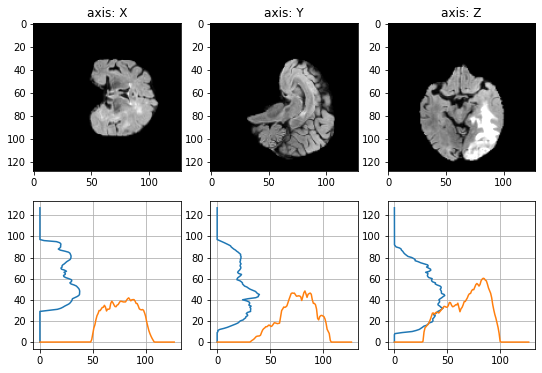

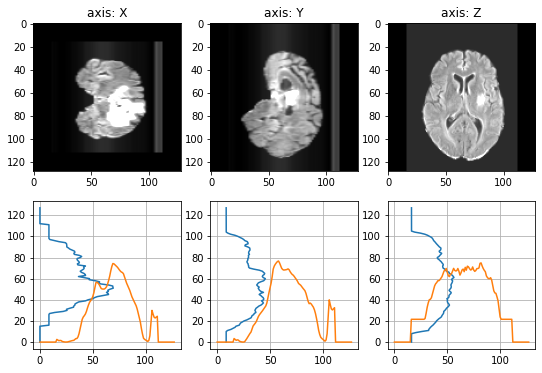

In [11]:
import os
import pandas as pd
import torch
from tqdm.auto import tqdm

from kaggle_brain3d.data import BrainScansDataset
from kaggle_brain3d.transforms import resize_volume

# ==============================

ds = BrainScansDataset(
    image_dir=os.path.join(PATH_DATASET, "train"),
    df_table=os.path.join(PATH_DATASET, "train_labels.csv"),
    crop_thr=None,
    cache_dir=PATH_TEMP,
)
for i in tqdm(range(2)):
    img = ds[i * 10]["data"]
    img = resize_volume(img[0])
    show_volume(img, fig_size=(9, 6))

### Lightning DataModule

It is constric to wrap all data-related peaces and define Pytoch dataloder for Training / Validation / Testing phase.

At the end we show a few sample images from the fost training batch.

preparing/caching scans @18 jobs:   0%|          | 0/400 [00:00<?, ?it/s]

Dataset >> mean: 0.13516660034656525 STD: 0.27310872077941895
Training batches: 61
Validation batches: 6
Test batches: 31
shape: torch.Size([224, 224, 224]), x=112, y=112, z=112  >> torch.float32
shape: torch.Size([224, 224, 224]), x=112, y=112, z=112  >> torch.float32


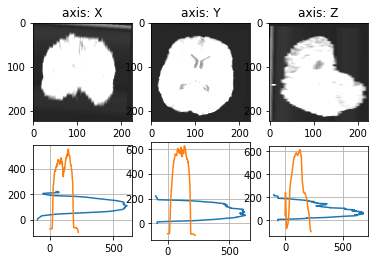

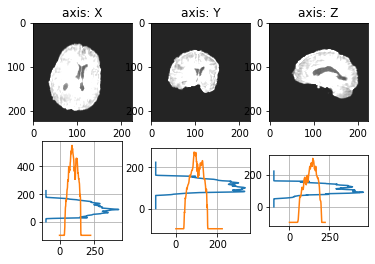

In [12]:
from functools import partial
import rising.transforms as rtr
from rising.loading import DataLoader, default_transform_call
from rising.random import DiscreteParameter, UniformParameter

from kaggle_brain3d.data import BrainScansDM, TRAIN_TRANSFORMS, VAL_TRANSFORMS
from kaggle_brain3d.transforms import RandomAffine, rising_zero_mean

# ==============================

dm = BrainScansDM(
    data_dir=PATH_DATASET,
    scan_types=["T1wCE"],
    # input_size=224,  # deprecated in v0.3
    vol_size=224,
    crop_thr=None,
    # crop_thr=1e-6,  # experimental crop threshold
    batch_size= 6,  # for full model training
    # batch_size=6,  # for finetune head
    # cache_dir=None,
    cache_dir=PATH_TEMP,
    in_memory=True,
    num_workers=10,
    split=0.9,
    train_transforms=rtr.Compose(TRAIN_TRANSFORMS, transform_call=default_transform_call),
    valid_transforms=rtr.Compose(VAL_TRANSFORMS, transform_call=default_transform_call),
)
dm.prepare_data(num_proc=18)
dm.setup()
# dm.prepare_data(num_proc=0, dataset=dm.test_dataset)
print(f"Training batches: {len(dm.train_dataloader())}")
print(f"Validation batches: {len(dm.val_dataloader())}")
print(f"Test batches: {len(dm.test_dataloader())}")

# Quick view
for batch in dm.train_dataloader():
    for i in range(2):
        show_volume(batch["data"][i][0], fig_size=(6, 4), v_min_max=(-1., 3.))
    break

## Prepare 3D model

LightningModule is the core of PL, it wrappes all model related peaces, mainly:

- the model/architecture/weights
- evaluation metrics
- configs for optimizer and LR scheduler

In [13]:
from torchsummary import summary
from kaggle_brain3d.models import LitBrainMRI, create_pretrained_medical_resnet
from monai.networks.nets import resnet10, resnet18, resnet34, resnet50, SEResNet50
from torch.optim import SGD, ASGD, Adamax

# ==============================

PATH_PRETRAINED_WEIGHTS = os.path.join(PATH_MODELS, "resnet_34_23dataset.pth")
net, pretraineds_layers = create_pretrained_medical_resnet(PATH_PRETRAINED_WEIGHTS, model_constructor=resnet34)

# net = SEResNet50(spatial_dims=3, in_channels=1, pretrained=True, num_classes=2)

model = LitBrainMRI(net=net, pretrained_params=None, lr=5e-4, optimizer=Adamax)
# summary(model, input_size=(1, 128, 128, 128))

/opt/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
model.device

device(type='cpu')

## Train a model

Lightning forces the following structure to your code which makes it reusable and shareable:

- Research code (the LightningModule).
- Engineering code (you delete, and is handled by the Trainer).
- Non-essential research code (logging, etc... this goes in Callbacks).
- Data (use PyTorch DataLoaders or organize them into a LightningDataModule).

Once you do this, you can train on multiple-GPUs, TPUs, CPUs and even in 16-bit precision without changing your code!

In [15]:
import pytorch_lightning as pl
from kaggle_brain3d.models import FineTuneCB

torch.backends.cudnn.enabled = False

csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.name)
tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs-tb/', name=model.name)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
fine = FineTuneCB(unfreeze_epoch=10)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid/auroc',
    save_top_k=1,
    save_last=True,
    filename='checkpoint/{epoch:02d}-{valid/auroc:.4f}',
    mode='max',
)

# ==============================

trainer = pl.Trainer(
    # overfit_batches=5,
    # fast_dev_run=True,
    gpus=[0],
    callbacks=[ckpt, fine],  #, swa
    logger=[csv_logger, tb_logger],
    max_epochs=35,
    precision=16,
    benchmark=True,
    accumulate_grad_batches=6, #12
    # val_check_interval=0.5,
    progress_bar_refresh_rate=1,
    log_every_n_steps=5,
    weights_summary='top',
    auto_lr_find=True,
#     auto_scale_batch_size='binsearch',
)

# ==============================

trainer.tune(
    model, 
    datamodule=dm, 
    lr_find_kwargs=dict(min_lr=2e-5, max_lr=1e-2, num_training=15),
    # scale_batch_size_kwargs=dict(max_trials=5),
)
print(f"Batch size: {dm.batch_size}")
print(f"Learning Rate: {model.learning_rate}")

# ==============================

# dm.batch_size = 12
print(model.device)
trainer.fit(model=model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name           | Type     | Params
--------------------------------------------
0 | net            | ResNet   | 63.5 M
1 | train_auroc    | AUROC    | 0     
2 | train_acc      | Accuracy | 0     
3 | train_f1_score | F1       | 0     
4 | val_auroc      | AUROC    | 0     
5 | val_acc        | Accuracy | 0     
6 | val_f1_score   | F1       | 0     
--------------------------------------------
63.5 M    Trainable params
0         Non-trainable params
63.5 M    Total params
253.884   Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/15 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Restored states from the checkpoint file at /DATA/DAT-BrainProj/kaggle_brain-tumor-3D/notebooks/lr_find_temp_model.ckpt
Learning rate set to 0.002885399811814428
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name           | Type     | Params
--------------------------------------------
0 | net            | ResNet   | 63.5 M
1 | train_auroc    | AUROC    | 0     
2 | train_acc      | Accuracy | 0     
3 | train_f1_score | F1       | 0     
4 | val_auroc      | AUROC    | 0     
5 | val_acc        | Accuracy | 0     
6 | val_f1_score   | F1       | 0     
--------------------------------------------
63.5 M    Trainable params
0         Non-trainable params
63.5 M    Total params
253.884   Total estimated model params size (MB)


Batch size: 6
Learning Rate: 0.002885399811814428
cuda:0


Validation sanity check: 0it [00:00, ?it/s]

Training: 23it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Training progress

logs/ResNet/version_4


,train/loss,train/acc,train/f1,epoch,step,train/auroc,valid/loss,valid/acc,valid/f1,valid/auroc
0,0.615850,0.333333,0.5,0,4,NaN,NaN,NaN,NaN,NaN
1,0.735904,0.666667,0.0,0,9,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0,11,0.446218,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0,11,NaN,0.680397,0.411765,0.0,0.557143
4,0.702152,0.500000,0.0,1,14,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='epoch'>

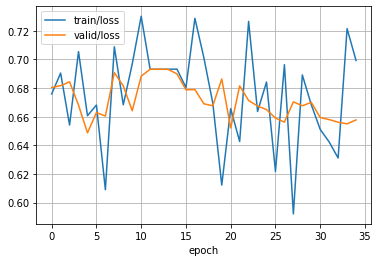

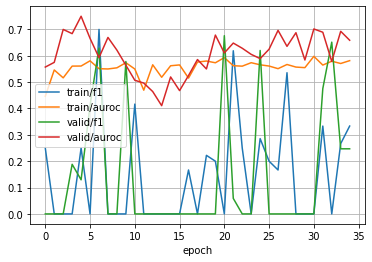

In [16]:
print(csv_logger.log_dir)
metrics = pd.read_csv(f'{csv_logger.log_dir}/metrics.csv')
display(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train/loss', 'valid/loss']].plot(grid=True, legend=True, xlabel=agg_col)
df_metrics[['train/f1', 'train/auroc', 'valid/f1', 'valid/auroc']].plot(grid=True, legend=True, xlabel=agg_col)

## Predictions

In [17]:
model.eval()
model.cpu()
submission = []

for batch in dm.test_dataloader():
    print(batch.keys())
    print(batch.get("label"))
    imgs = batch.get("data")
    print(imgs.shape)
    with torch.no_grad():
        preds = model(imgs)
    print(preds)
    probs = torch.nn.functional.softmax(preds)
    print(probs)
    break

dict_keys(['data', 'label'])
['00802/T1wCE', '00502/T1wCE', '00008/T1wCE', '00407/T1wCE', '00209/T1wCE', '00625/T1wCE']
torch.Size([6, 1, 224, 224, 224])
tensor([0.1013, 0.4991, 0.4940, 0.4975, 0.0569, 0.4988])
tensor([0.1266, 0.1884, 0.1875, 0.1881, 0.1211, 0.1884])


/tmp/ipykernel_77424/4130118031.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(preds)


In [20]:
from kaggle_brain3d.models import make_submission

dm.batch_size = 2
df_submission = make_submission(model, dm.test_dataloader(), "cuda" if torch.cuda.is_available() else "cpu")
display(df_submission)
df_submission["MGMT_value"].to_csv("submission.csv")

  0%|          | 0/93 [00:00<?, ?it/s]

,BraTS21ID5,MRI_type,MGMT_value
BraTS21ID,,,
802,00802,T1wCE,0.101741
502,00502,T1wCE,0.499139
8,00008,T1wCE,0.494023
407,00407,T1wCE,0.497537
209,00209,T1wCE,0.056910
...,...,...,...
12,00012,T1wCE,0.498533
547,00547,T1wCE,0.501035
796,00796,T1wCE,0.000062


array([[<AxesSubplot:title={'center':'MGMT_value'}>]], dtype=object)

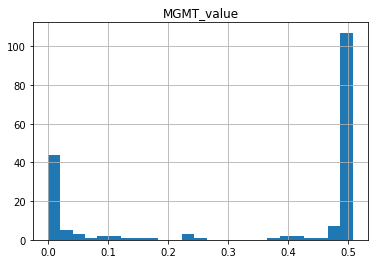

In [21]:
df_submission[["MGMT_value"]].hist(bins=25)